In [6]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score

# Function to discretize variables
def discretize(x, num_bins=10):
    return np.digitize(x, bins=np.linspace(np.min(x), np.max(x), num=num_bins))

# Function to compute mutual information between two discretized variables
def mutual_information(x, y, num_bins=10):
    c_xy = np.histogram2d(x, y, bins=num_bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Parameters for the task
n = 1000
rho_values = [0, 0.5, 0.8, 0.9, 1]
N = 100
bins = 10


<Figure size 600x500 with 0 Axes>

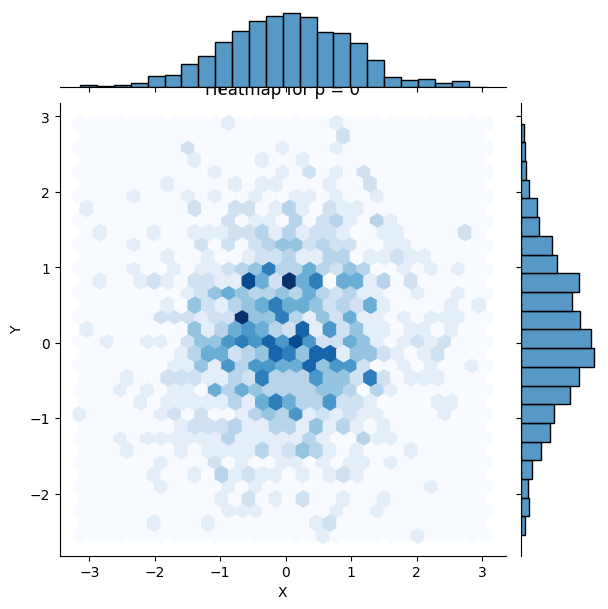

<Figure size 600x500 with 0 Axes>

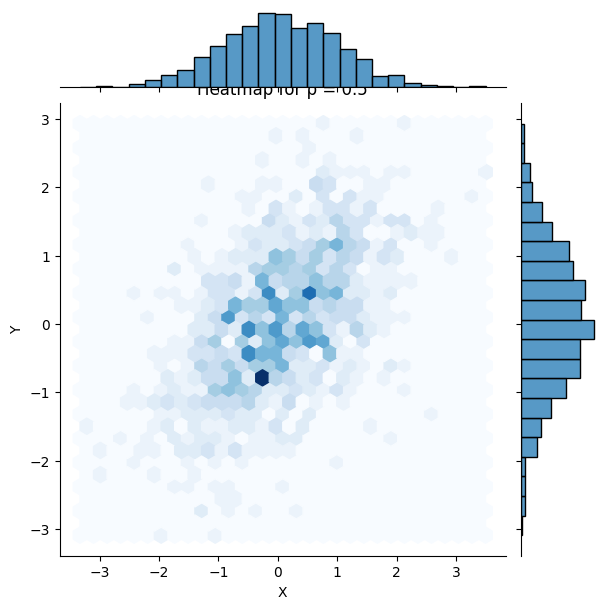

<Figure size 600x500 with 0 Axes>

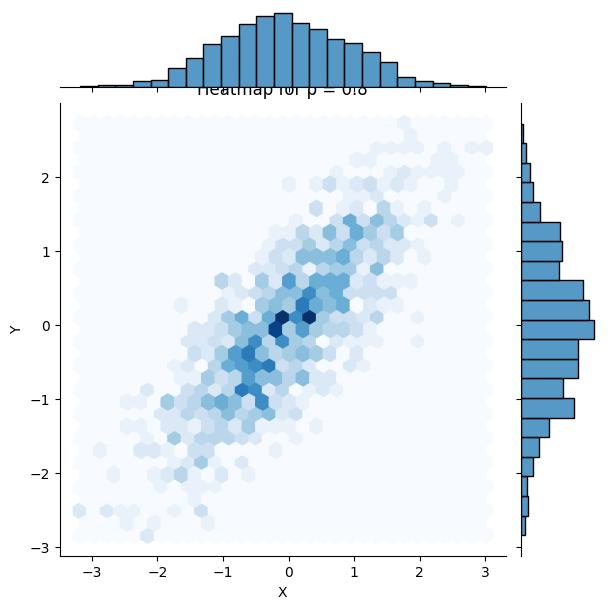

<Figure size 600x500 with 0 Axes>

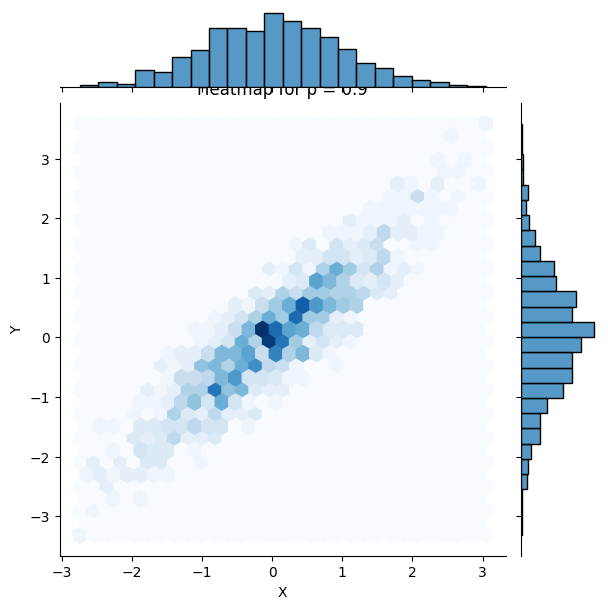

<Figure size 600x500 with 0 Axes>

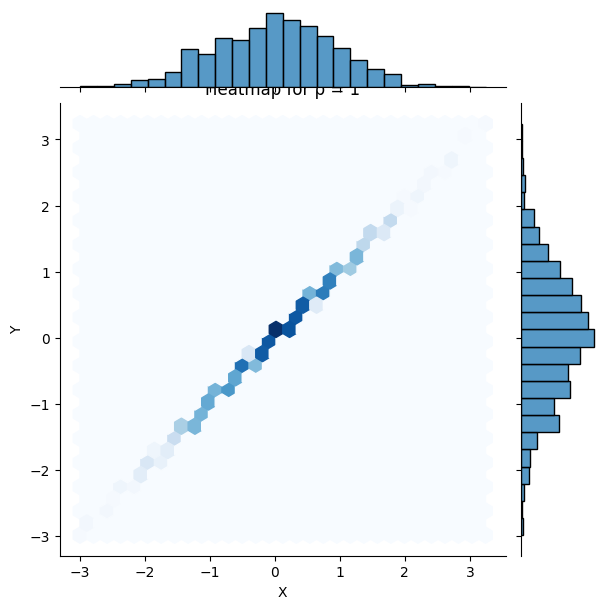

In [ ]:
rows = len(rho_values)
mi_scores = [[] for _ in range(rows)]
pearson_corrs = [[] for _ in range(rows)]
# Iterate over different values of rho
for i,rho in enumerate(rho_values):
    # Generate and visualize the distribution for each rho value
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    X, Y = np.random.multivariate_normal(mean, cov, n).T
    plt.figure(figsize=(6, 5))
    sns.jointplot(x=X, y=Y, kind='hex', gridsize=30, cmap='Blues')
    plt.title(f'Heatmap for ρ = {rho}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    # Repeat experiments and calculate metrics
    for _ in range(N):
        X, Y = np.random.multivariate_normal(mean, cov, n).T
        pearson_corr, _ = pearsonr(X, Y)
        mi_score = mutual_information(X, Y, bins)
        pearson_corrs[i].append(pearson_corr)
        mi_scores[i].append((mi_score))


In [ ]:
def are_rows_identical(matrix):
    first_row = matrix[0]  # Store the first row to compare with others
    for row in matrix[1:]:  # Iterate over the rest of the rows
        if row != first_row:  # Compare each row with the first row
            return False  # Return False if any row is not identical
    return True
are_rows_identical(mi_scores)

False

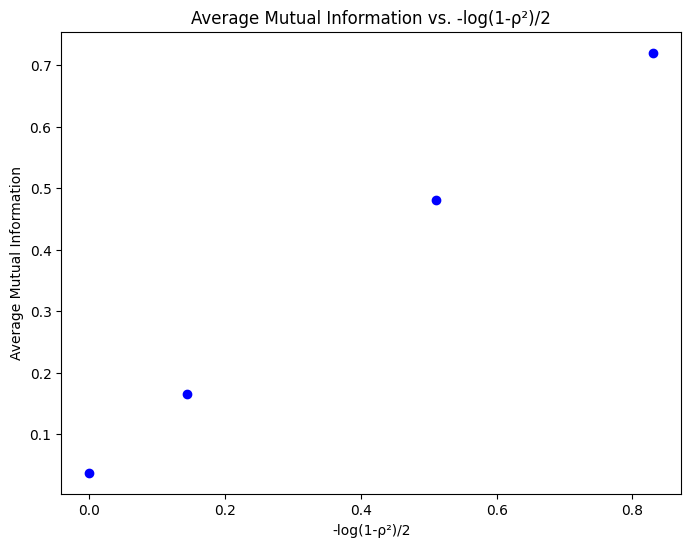

In [ ]:
log_rho_terms = np.array([-np.log(1 - rho**2) / 2 if rho < 1 else float('inf') for rho in rho_values])
average_mi_scores = np.array([np.mean(mi_score) for mi_score in mi_scores])
# Ensure sizes match for plotting

# Corrected scatter plot for mutual information
plt.figure(figsize=(8, 6))
plt.scatter(log_rho_terms, average_mi_scores, color='blue')
plt.title('Average Mutual Information vs. -log(1-ρ²)/2')
plt.xlabel('-log(1-ρ²)/2')
plt.ylabel('Average Mutual Information')
plt.show()


Task Two

In [8]:
from scipy.stats import chi2_contingency, chi2

def asymptotic_independence_test(X, Y, stats_type='mi', bins=10):
    # Discretize variables
    X_binned = discretize(X, bins)
    Y_binned = discretize(Y, bins)
    contingency_table = np.histogram2d(X_binned, Y_binned, bins=bins)[0]

    if stats_type == 'mi':
        # Calculate mutual information and convert it to a chi-squared statistic
        mi = mutual_info_score(None, None, contingency=contingency_table)
        test_stat = 2 * n * mi
    elif stats_type == 'chi2':
        # Direct calculation of the chi-squared statistic from the contingency table
        test_stat, _, _, _ = chi2_contingency(contingency_table)
    else:
        raise ValueError("Invalid stats_type. Use 'mi' or 'chi2'.")

    # Degrees of freedom: (num_bins - 1)^2 for a contingency table of size num_bins x num_bins
    dof = (bins - 1) ** 2
    # Calculate p-value
    p_value = 1 - chi2.cdf(test_stat, dof)

    return test_stat, p_value

def asymptotic_independence_test_safe(X, Y, stats_type='mi', bins=10):
    try:
        # Existing test code remains the same
        return asymptotic_independence_test(X, Y, stats_type, bins)
    except ValueError as e:
        # Handle cases with zero expected frequencies
        print(f"Error in computing {stats_type} test: {e}")
        return float('nan'), float('nan')  # Return NaN values if there's an error


In [2]:
def permutation_independence_test(X, Y, B=1000, bins=10):
    original_mi = mutual_information(X, Y, bins)
    count = 0

    for _ in range(B):
        # Random permutation of X
        X_permuted = np.random.permutation(X)
        mi_permuted = mutual_information(X_permuted, Y, bins)

        # Compare original and permuted mutual information
        if mi_permuted >= original_mi:
            count += 1

    # Compute p-value
    p_value = (count + 1) / (B + 1)  # Adding one for the observed value

    return original_mi, p_value


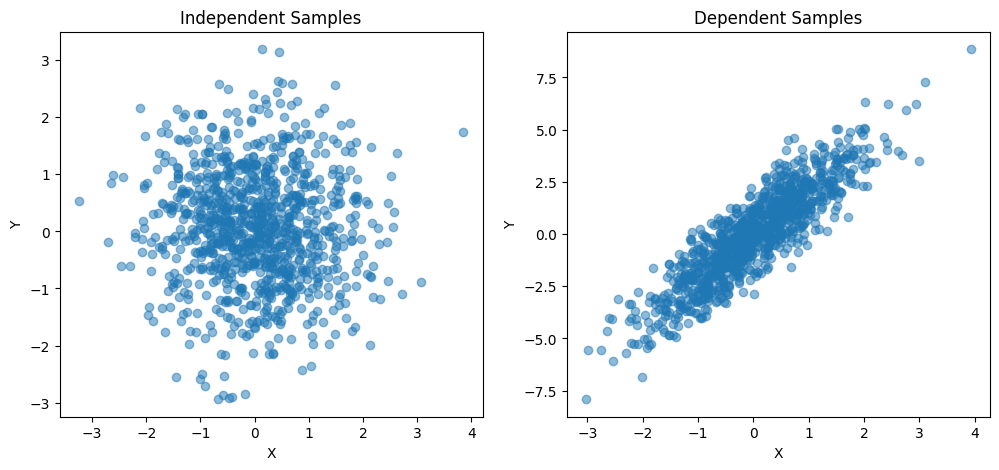

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Sample size
n = 1000

# Independent samples
X_indep = np.random.normal(0, 1, n)  # X from a normal distribution
Y_indep = np.random.normal(0, 1, n)  # Y from a normal distribution, independent of X

# Dependent samples (let's create a linear relationship)
X_dep = np.random.normal(0, 1, n)  # X from a normal distribution
Y_dep = 2 * X_dep + np.random.normal(0, 1, n)  # Y depends on X plus some noise

# Visualize the samples
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_indep, Y_indep, alpha=0.5)
plt.title('Independent Samples')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.scatter(X_dep, Y_dep, alpha=0.5)
plt.title('Dependent Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [9]:
# Let's use the previously defined functions
# Assuming asymptotic_independence_test and permutation_independence_test are already defined

bins_reduced = 5  # Reduced number of bins to mitigate zero expected counts

# Apply tests to independent samples
print("Independent Samples:")
test_stat_mi_indep, p_value_mi_indep = asymptotic_independence_test_safe(X_indep, Y_indep, 'mi', bins_reduced)
test_stat_chi2_indep, p_value_chi2_indep = asymptotic_independence_test_safe(X_indep, Y_indep, 'chi2', bins_reduced)
print(f'MI Test: statistic = {test_stat_mi_indep}, p-value = {p_value_mi_indep}')
print(f'Chi2 Test: statistic = {test_stat_chi2_indep}, p-value = {p_value_chi2_indep}')

# Apply permutation test
original_mi_indep, p_value_perm_indep = permutation_independence_test(X_indep, Y_indep, B=1000)
print(f'Permutation Test: original MI = {original_mi_indep}, p-value = {p_value_perm_indep}\n')

# Apply tests to dependent samples
print("Dependent Samples:")
test_stat_mi_dep, p_value_mi_dep = asymptotic_independence_test_safe(X_dep, Y_dep, 'mi', bins_reduced)
test_stat_chi2_dep, p_value_chi2_dep = asymptotic_independence_test_safe(X_dep, Y_dep, 'chi2', bins_reduced)
print(f'MI Test: statistic = {test_stat_mi_dep}, p-value = {p_value_mi_dep}')
print(f'Chi2 Test: statistic = {test_stat_chi2_dep}, p-value = {p_value_chi2_dep}')

# Apply permutation test
original_mi_dep, p_value_perm_dep = permutation_independence_test(X_dep, Y_dep, B=1000)
print(f'Permutation Test: original MI = {original_mi_dep}, p-value = {p_value_perm_dep}')


Independent Samples:
MI Test: statistic = 18.20405649726903, p-value = 0.31208400576044437
Chi2 Test: statistic = 28.228089713785256, p-value = 0.02969185448011824
Permutation Test: original MI = 0.03994989670281023, p-value = 0.3336663336663337

Dependent Samples:
MI Test: statistic = 703.4618670329105, p-value = 0.0
Chi2 Test: statistic = 1886.9135601729618, p-value = 0.0
Permutation Test: original MI = 0.6572618320812723, p-value = 0.000999000999000999
